In [1]:
import os
import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.signal import butter
from scipy.signal import filtfilt as filt

In [2]:
# Set param
indir = 'coare'
outdir = 'fig'
wave_age = True
sea_state = True

suffix = '_wa_ss' if wave_age and sea_state else '_wa' if wave_age else ''
base_subdirs = ['ram', 'rom', 'rcm']
subdir_list = base_subdirs + [f'rcm_rs{suffix}', f'rcm_rs_wm{suffix}']
labels = ['RAM', 'ROM', 'RCM', 'RCM-RS', 'RCM-RS-WM']

# Open data
ds = []
for subdir in subdir_list:
    ds.append(Dataset(os.path.join(indir, subdir, 'stats_rot.nc'), 'r'))

# Read axis
t = ds[0].variables['t'][:].data
za = ds[0].variables['za'][:].data
zo = ds[0].variables['zo'][::-1].data # reverse for plot

# Read LOTUS data
data = np.load('LOTUS3_rot_data.npz')
zo_ref = data['z'][:-2]
um_ref = data['umean'][:-2]
vm_ref = data['vmean'][:-2]
ue_ref = data['uerr'][:-2]
ve_ref = data['verr'][:-2]
us_ref = data['ustd'][:-2]
vs_ref = data['vstd'][:-2]
data.close()

In [3]:
# Set plot param
lowpass_filt = True # lowpass filtering of time series
time_mean = True # time-averaging of ensemble stats. 
day0 = 10. # starting day for average
it0 = np.argmin(abs(t - day0))
colors = plt.get_cmap('tab10').colors[:len(ds)]
fig_kwargs = {'dpi':300, 'bbox_inches':'tight', 'pad_inches':0}
os.makedirs(outdir) if not os.path.isdir(outdir) else None

# Define low-pass filter 
dt = t[1] - t[0] # days
fs = 1./dt # samp. freq.
fc = 1./0.5 # cutoff freq. (1/days)
wid = fc/(fs/2)
num, denom = butter(5, wid, 'low') # 5th order Butterworth

def set_plot_style(ax, fontsize=9, grid='both', sci_format=None):
    """
    Set consistent font sizes, grid, and axis formatting for a matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to style.
        fontsize (int): Font size for title, labels, ticks, and legend.
        grid (str or None): Enable grid ('x', 'y', 'both', or None).
        sci_format (str or None): Use scientific notation ('x', 'y', or 'both').
    """
    # Set title and axis labels
    ax.set_title(ax.get_title(), fontsize=fontsize)
    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize)

    # Set tick labels font size
    ax.tick_params(axis='both', labelsize=fontsize-1)
    
    # Apply scientific notation if specified
    if sci_format in ['x', 'both']:
        ax.xaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        ax.xaxis.get_offset_text().set_fontsize(fontsize-1)
    if sci_format in ['y', 'both']:
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        ax.yaxis.get_offset_text().set_fontsize(fontsize-1)

    # Enable grid with specific axis control
    if grid == 'x':
        ax.grid(True, which='major', axis='x', linestyle='--', linewidth=0.6, alpha=0.7)
    elif grid == 'y':
        ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.6, alpha=0.7)
    elif grid == 'both':
        ax.grid(True, which='major', linestyle='--', linewidth=0.6, alpha=0.7)

    # Set legend font size if legend exists
    if ax.get_legend() is not None:
        ax.legend(fontsize=fontsize)

# lambda function to auto. fix axis limits
alim = lambda amin, amax, cp=0.75: [
    amin - (1 - cp) * (amax - amin) / 2, 
    amax + (1 - cp) * (amax - amin) / 2
]

# Barplot arguments
bar_kwargs = dict(
    align='center',
    alpha=0.6,
    edgecolor='black',
    capsize=8,
    error_kw={'elinewidth': 1.2, 'capthick': 1}  # Control error bar thickness
)

# Errorbar arguments for LOTUS data
lotus_kwargs = {
    'fmt':'ko', 
    'capsize':2, 
    'markersize':2, 
    'lw':1, 
    'label':'LOTUS3 CI'
}

## Vertical Profiles

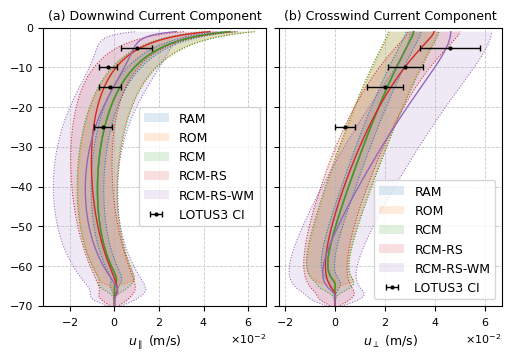

In [4]:
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(5,3.5))

for i, d in enumerate(ds):
    fm = d.variables['uo_mean'][it0:,::-1].data.mean(axis=0) if time_mean else ds_ram.variables['uo_mean'][-1,::-1].data
    fs = d.variables['uo_std'][it0:,::-1].data.mean(axis=0) if time_mean else ds_ram.variables['uo_std'][-1,::-1].data
    ax[0].plot(fm, zo, lw=1)
    ax[0].fill_betweenx(zo, fm-fs, fm+fs, alpha=0.15, label=labels[i])
    ax[0].plot(fm-fs, zo, linestyle=':', lw=0.75, color=colors[i])
    ax[0].plot(fm+fs, zo, linestyle=':', lw=0.75, color=colors[i])

    fm = d.variables['vo_mean'][it0:,::-1].data.mean(axis=0) if time_mean else ds_ram.variables['vo_mean'][-1,::-1].data
    fs = d.variables['vo_std'][it0:,::-1].data.mean(axis=0) if time_mean else ds_ram.variables['vo_std'][-1,::-1].data
    ax[1].plot(fm, zo, lw=1)
    ax[1].fill_betweenx(zo, fm-fs, fm+fs, alpha=0.15, label=labels[i])
    ax[1].plot(fm-fs, zo, linestyle=':', lw=0.75, color=colors[i])
    ax[1].plot(fm+fs, zo, linestyle=':', lw=0.75, color=colors[i])

ax[0].errorbar(um_ref[::-1], zo_ref[::-1], xerr=ue_ref[::-1], **lotus_kwargs)
ax[1].errorbar(vm_ref[::-1], zo_ref[::-1], xerr=ve_ref[::-1], **lotus_kwargs)

ax[0].set(
    ylim=(-70,0), 
    title='(a) Downwind Current Component',
    xlabel=r'$u_{\parallel}$ (m/s)'
)

ax[1].set(
    title='(b) Crosswind Current Component',
    xlabel=r'$u_{\perp}$ (m/s)'
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a, sci_format='x')

plt.savefig(os.path.join(outdir, f'ocvel{suffix}.pdf'), **fig_kwargs) 

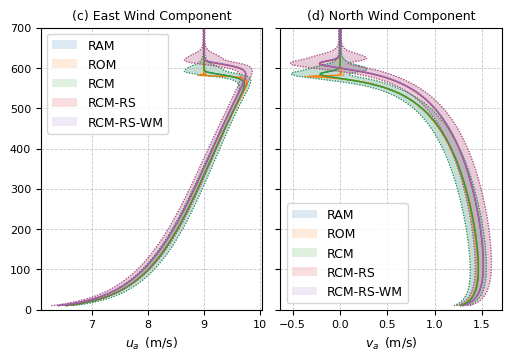

In [5]:
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(5,3.5))

for i, d in enumerate(ds):
    fm = d.variables['ua_mean'][it0:].data.mean(axis=0) if time_mean else ds_ram.variables['ua_mean'][-1].data
    fs = d.variables['ua_std'][it0:].data.mean(axis=0) if time_mean else ds_ram.variables['ua_std'][-1].data
    ax[0].plot(fm, za, lw=1)
    ax[0].fill_betweenx(za, fm-fs, fm+fs, alpha=0.15, label=labels[i])
    ax[0].plot(fm-fs, za, linestyle=':', lw=0.75, color=colors[i])
    ax[0].plot(fm+fs, za, linestyle=':', lw=0.75, color=colors[i])

    fm = d.variables['va_mean'][it0:].data.mean(axis=0) if time_mean else ds_ram.variables['va_mean'][-1].data
    fs = d.variables['va_std'][it0:].data.mean(axis=0) if time_mean else ds_ram.variables['va_std'][-1].data
    ax[1].plot(fm, za, lw=1)
    ax[1].fill_betweenx(za, fm-fs, fm+fs, alpha=0.15, label=labels[i])
    ax[1].plot(fm-fs, za, linestyle=':', lw=0.75, color=colors[i])
    ax[1].plot(fm+fs, za, linestyle=':', lw=0.75, color=colors[i])

ax[0].set(
    ylim=(0,700), 
    title='(c) East Wind Component',
    xlabel=r'$u_a\,$ (m/s)'
)

ax[1].set(
    title='(d) North Wind Component',
    xlabel=r'$v_a\,$ (m/s)'
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a)

plt.savefig(os.path.join(outdir, f'atvel{suffix}.pdf'), **fig_kwargs)

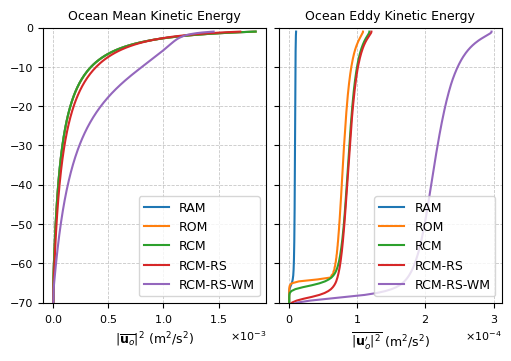

In [6]:
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(5,3.5))

for i, d in enumerate(ds):
    fz = d.variables['mkeo'][it0:,::-1].data.mean(axis=0) if time_mean else d.variables['mkeo'][-1,::-1].data
    ax[0].plot(fz, zo, label=labels[i])
    
    fz = d.variables['ekeo'][it0:,::-1].data.mean(axis=0) if time_mean else d.variables['ekeo'][-1,::-1].data
    ax[1].plot(fz, zo, label=labels[i])    

ax[0].set(
    ylim=(-70,0), 
    title='Ocean Mean Kinetic Energy',
    xlabel=r'$|\overline{\mathbf{u}_o}|^2$ (m$^2$/s$^2$)'
)

ax[1].set(
    title='Ocean Eddy Kinetic Energy',
    xlabel=r'$\overline{|\mathbf{u}_o^\prime|^2}$ (m$^2$/s$^2$)'
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a, sci_format='x')

plt.savefig(os.path.join(outdir, f'ocdke{suffix}.pdf'), **fig_kwargs) 

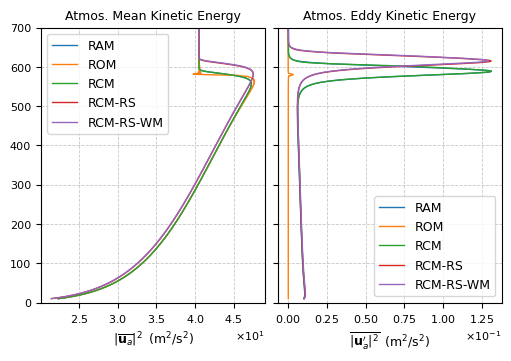

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True, constrained_layout=True, figsize=(5,3.5))

for i, d in enumerate(ds):
    fz = d.variables['mkea'][it0:].data.mean(axis=0) if time_mean else d.variables['mkea'][-1].data
    ax[0].plot(fz, za, lw=1, label=labels[i])
    
    fz = d.variables['ekea'][it0:].data.mean(axis=0) if time_mean else d.variables['ekea'][-1].data
    ax[1].plot(fz, za, lw=1, label=labels[i])    

ax[0].set(
    ylim=(0,700), 
    title='Atmos. Mean Kinetic Energy',
    xlabel=r'$|\overline{\mathbf{u}_a}|^2\,$ (m$^2$/s$^2$)'
)

ax[1].set(
    title='Atmos. Eddy Kinetic Energy',
    xlabel=r'$\overline{|\mathbf{u}_a^\prime|^2}\,$ (m$^2$/s$^2$)'
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a, sci_format='x')

plt.savefig(os.path.join(outdir, f'atdke{suffix}.pdf'), **fig_kwargs) 

## Time Series

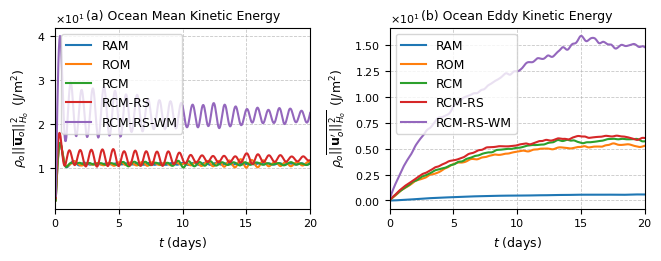

In [8]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.5,2.5))

xt0 = np.linspace(0,t[-1],5)

for i, d in enumerate(ds):
    ft = filt(num, denom, d.variables['mkeo_int'][:].data) if lowpass_filt else d.variables['mkeo_int'][:].data
    ax[0].plot(t, ft, label=labels[i])
    
    ft = filt(num, denom, d.variables['ekeo_int'][:].data) if lowpass_filt else d.variables['ekeo_int'][:].data
    ax[1].plot(t, ft, label=labels[i])

ax[0].set(
    xticks=xt0, 
    xlim=(xt0[0],xt0[-1]),
    xlabel='$t$ (days)',
    ylabel=r'$\rho_o ||\overline{\mathbf{u}_o}||_{H_o}^2\,$ (J/m$^2$)',
    title='(a) Ocean Mean Kinetic Energy',
)

ax[1].set(
    xlabel='$t$ (days)',    
    ylabel= r'$\rho_o \overline{||\mathbf{u}_o^\prime||_{H_o}^2}\,$ (J/m$^2$)',
    title='(b) Ocean Eddy Kinetic Energy',
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a, sci_format='y')

plt.savefig(os.path.join(outdir, f'ocke{suffix}.pdf'), **fig_kwargs)    

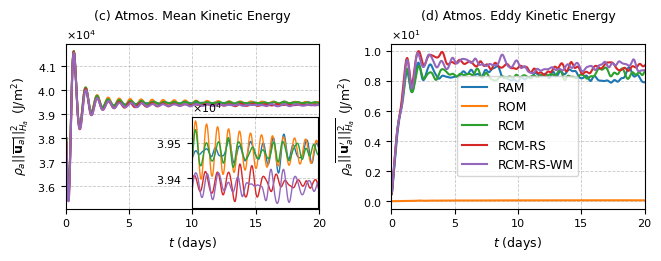

In [9]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.5,2.5))
axins = inset_axes(
    ax[0], width="50%", height="55%", loc="lower right", 
    bbox_to_anchor=(0.025, -0.035, 1, 1), bbox_transform=ax[0].transAxes
) 

day = 10. # starting day for plot
it = np.argmin(abs(t - day))
xt = np.linspace(t[it],t[-1],4)

for i, d in enumerate(ds):
    ft = filt(num, denom, d.variables['mkea_int'][:].data) if lowpass_filt else d.variables['mkea_int'][:].data
    ax[0].plot(t, ft)
    axins.plot(t[it:], ft[it:], lw=1)
    
    ft = filt(num, denom, d.variables['ekea_int'][:].data) if lowpass_filt else d.variables['ekea_int'][:].data
    ax[1].plot(t, ft, label=labels[i])

ax[0].set(
    xticks=xt0, 
    xlim=(xt0[0],xt0[-1]),
    xlabel='$t$ (days)',
    title='(c) Atmos. Mean Kinetic Energy',
    ylabel=r'$\rho_a ||\overline{\mathbf{u}_a}||_{H_a}^2\,$ (J/m$^2$)'
)
axins.set(xlim=(t[it],t[-1]))
axins.sharex = ax[0]  # Explicitly share x-axis
axins.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide ticks

ax[1].set(
    xlabel='$t$ (days)',
    title='(d) Atmos. Eddy Kinetic Energy',
    ylabel=r'$\rho_a \overline{||\mathbf{u}_a^\prime||_{H_a}^2}\,$ (J/m$^2$)'
)
ax[1].legend(loc='best')

for a in ax: 
    set_plot_style(a, sci_format='y')
set_plot_style(axins, sci_format='y')

plt.savefig(os.path.join(outdir, f'atke{suffix}.pdf'), **fig_kwargs)

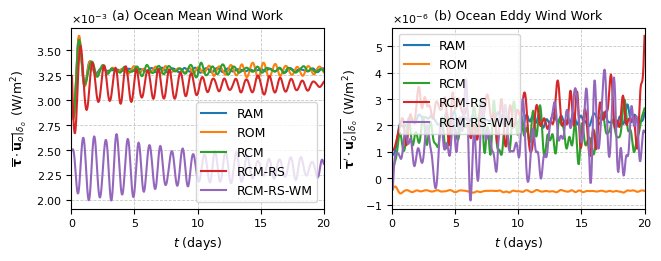

In [10]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.5,2.5))

for i, d in enumerate(ds):
    ft = filt(num, denom, d.variables['mwwo'][:].data) if lowpass_filt else d.variables['mwwo'][:].data
    ax[0].plot(t, ft, label=labels[i])
    
    ft = filt(num, denom, d.variables['ewwo'][:].data) if lowpass_filt else d.variables['ewwo'][:].data
    ax[1].plot(t, ft, label=labels[i])

ax[0].set(
    xticks=xt0, 
    xlim=(xt0[0],xt0[-1]),
    xlabel='$t$ (days)',    
    ylabel=r'$\overline{\mathbf{\tau}} \cdot \overline{\mathbf{u}_o}|_{\delta_o}\,$ (W/m$^2$)',
    title='(a) Ocean Mean Wind Work',
)

ax[1].set(
    xlabel='$t$ (days)',    
    ylabel=r'$\overline{\mathbf{\tau}^\prime \cdot \mathbf{u}_o^\prime|_{\delta_o}}\,$ (W/m$^2$)',
    title='(b) Ocean Eddy Wind Work',
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a, sci_format='y')

plt.savefig(os.path.join(outdir, f'ocwrk{suffix}.pdf'), **fig_kwargs)    

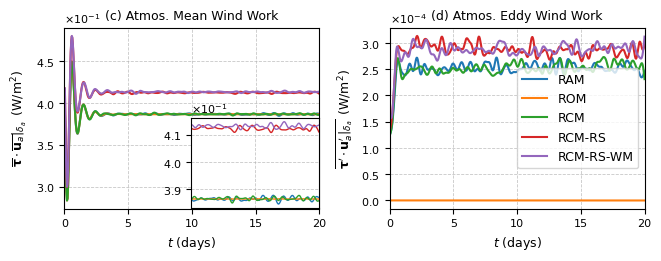

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.5,2.5))
axins = inset_axes(
    ax[0], width="50%", height="50%", loc="lower right", 
    bbox_to_anchor=(0.025, -0.035, 1, 1), bbox_transform=ax[0].transAxes
) 

for i, d in enumerate(ds):
    ft = filt(num, denom, d.variables['mwwa'][:].data) if lowpass_filt else d.variables['mwwa'][:].data
    ax[0].plot(t, ft)
    axins.plot(t[it:], ft[it:], lw=1)
    
    ft = filt(num, denom, d.variables['ewwa'][:].data) if lowpass_filt else d.variables['ewwa'][:].data
    ax[1].plot(t, ft, label=labels[i])

ax[0].set(
    xticks=xt0, 
    xlim=(xt0[0],xt0[-1]),
    xlabel='$t$ (days)',
    title='(c) Atmos. Mean Wind Work',
    ylabel=r'$\overline{\mathbf{\tau}} \cdot \overline{\mathbf{u}_a}|_{\delta_a}\,$ (W/m$^2$)'
)
axins.set(xlim=(t[it],t[-1]))
axins.sharex = ax[0]  # Explicitly share x-axis
axins.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide ticks

ax[1].set(
    xlabel='$t$ (days)',
    title='(d) Atmos. Eddy Wind Work',
    ylabel=r'$\overline{\mathbf{\tau}^\prime \cdot \mathbf{u}_a^\prime|_{\delta_a}}\,$ (W/m$^2$)'
)
ax[1].legend(loc='best')

for a in ax: 
    set_plot_style(a, sci_format='y')
set_plot_style(axins, sci_format='y')

plt.savefig(os.path.join(outdir, f'atwrk{suffix}.pdf'), **fig_kwargs)

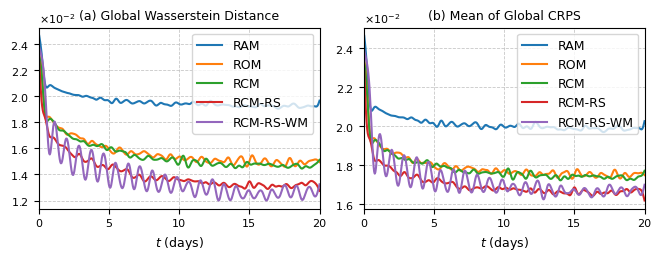

In [12]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.5,2.5))

for i, d in enumerate(ds):    
    ft = filt(num, denom, d.variables['mean_wdist'][:].data) if lowpass_filt else d.variables['mean_wdist'][:].data
    ax[0].plot(t, ft, label=labels[i])

    ft = filt(num, denom, d.variables['mean_crps'][:].data) if lowpass_filt else d.variables['mean_crps'][:].data
    ax[1].plot(t, ft, label=labels[i])

ax[0].set(
    xticks=xt0, 
    xlim=(xt0[0],xt0[-1]),
    xlabel='$t$ (days)', 
    title='(a) Global Wasserstein Distance',
)

ax[1].set(
    xlabel='$t$ (days)', 
    title='(b) Mean of Global CRPS'
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a, sci_format='y')

plt.savefig(os.path.join(outdir, f'score{suffix}.pdf'), **fig_kwargs)

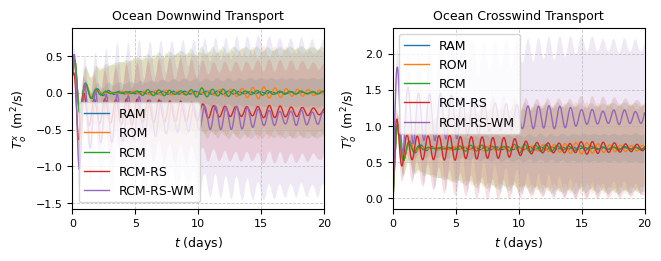

In [13]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.5,2.5))

for i, d in enumerate(ds):
    fm = filt(num, denom, d.variables['Txo_mean'][:].data) if lowpass_filt else d.variables['Txo_mean'][:].data
    fs = filt(num, denom, d.variables['Txo_std'][:].data) if lowpass_filt else d.variables['Txo_std'][:].data
    ax[0].plot(t, fm, lw=1, label=labels[i])
    ax[0].fill_between(t, fm-fs, fm+fs, alpha=0.15)
    
    fm = filt(num, denom, d.variables['Tyo_mean'][:].data) if lowpass_filt else d.variables['Tyo_mean'][:].data
    fs = filt(num, denom, d.variables['Tyo_std'][:].data) if lowpass_filt else d.variables['Tyo_std'][:].data
    ax[1].plot(t, fm, lw=1, label=labels[i])
    ax[1].fill_between(t, fm-fs, fm+fs, alpha=0.15)    

ax[0].set(
    xticks=xt0, 
    xlim=(xt0[0],xt0[-1]),
    xlabel='$t$ (days)', 
    title='Ocean Downwind Transport',
    ylabel=r'$T_o^x\,$ (m$^2$/s)'
)

ax[1].set(
    xlabel='$t$ (days)', 
    title='Ocean Crosswind Transport',
    ylabel=r'$T_o^y\,$ (m$^2$/s)'
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a)

plt.savefig(os.path.join(outdir, f'octp{suffix}.pdf'), **fig_kwargs) 

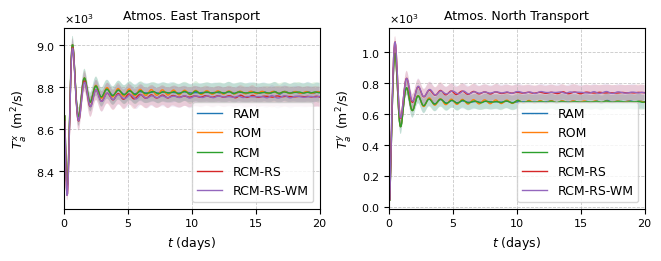

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.5,2.5))

for i, d in enumerate(ds):
    fm = filt(num, denom, d.variables['Txa_mean'][:].data) if lowpass_filt else d.variables['Txa_mean'][:].data
    fs = filt(num, denom, d.variables['Txa_std'][:].data) if lowpass_filt else d.variables['Txa_std'][:].data
    #ax[0].plot(t[it:], fm[it:], lw=1, label=labels[i])
    #ax[0].fill_between(t[it:], (fm-fs)[it:], (fm+fs)[it:], alpha=0.15)
    ax[0].plot(t, fm, lw=1, label=labels[i])
    ax[0].fill_between(t, fm-fs, fm+fs, alpha=0.15)
    
    fm = filt(num, denom, d.variables['Tya_mean'][:].data) if lowpass_filt else d.variables['Tya_mean'][:].data
    fs = filt(num, denom, d.variables['Tya_std'][:].data) if lowpass_filt else d.variables['Tya_std'][:].data
    #ax[1].plot(t[it:], fm[it:], lw=1, label=labels[i])
    #ax[1].fill_between(t[it:], (fm-fs)[it:], (fm+fs)[it:], alpha=0.15)    
    ax[1].plot(t, fm, lw=1, label=labels[i])
    ax[1].fill_between(t, fm-fs, fm+fs, alpha=0.15)    

ax[0].set(
    xticks=xt0, 
    xlim=(xt0[0],xt0[-1]),
    xlabel='$t$ (days)', 
    title='Atmos. East Transport',
    ylabel=r'$T_a^x\,$ (m$^2$/s)'
)

ax[1].set(
    xlabel='$t$ (days)', 
    title='Atmos. North Transport',
    ylabel=r'$T_a^y\,$ (m$^2$/s)'
)

for a in ax: 
    a.legend(loc='best')
    set_plot_style(a, sci_format='y')

plt.savefig(os.path.join(outdir, f'attp{suffix}.pdf'), **fig_kwargs) 

## Barplots

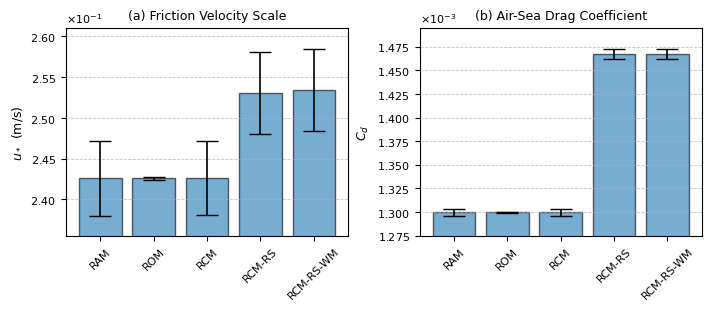

In [15]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(7,3))

xpos = np.arange(len(ds))
ymean = np.array([d.variables['ustar_mean'][it0:].data.mean(axis=0) for d in ds])
ystd = np.array([d.variables['ustar_std'][it0:].data.mean(axis=0) for d in ds])
ax[0].bar(xpos, ymean, yerr=ystd, **bar_kwargs)
ax[0].set(
    xticks=xpos, 
    xticklabels=labels,
    title='(a) Friction Velocity Scale',
    ylabel='$u_*\,$ (m/s)',
    ylim=alim((ymean-ystd).min(), (ymean+ystd).max())
)

ymean = np.array([d.variables['Cd_mean'][it0:].data.mean(axis=0) for d in ds])
ystd = np.array([d.variables['Cd_std'][it0:].data.mean(axis=0) for d in ds])
ax[1].bar(xpos, ymean, yerr=ystd, **bar_kwargs)
ax[1].set(
    title='(b) Air-Sea Drag Coefficient',
    ylabel='$C_d$',
    ylim=alim((ymean-ystd).min(), (ymean+ystd).max())
)

for a in ax: 
    a.tick_params(axis='x', rotation=45)
    set_plot_style(a, grid='y', sci_format='y')

plt.savefig(os.path.join(outdir, f'bulk{suffix}.pdf'), **fig_kwargs) 

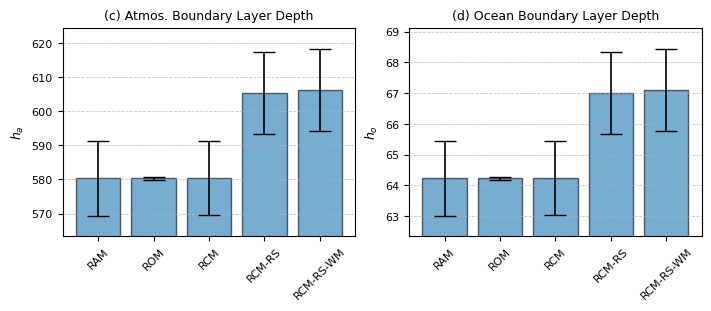

In [16]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(7,3))

ymean = np.array([d.variables['ha_mean'][it0:].data.mean(axis=0) for d in ds])
ystd = np.array([d.variables['ha_std'][it0:].data.mean(axis=0) for d in ds])
ax[0].bar(xpos, ymean, yerr=ystd, **bar_kwargs)
ax[0].set(
    xticks=xpos, 
    xticklabels=labels,    
    title='(c) Atmos. Boundary Layer Depth',
    ylabel='$h_a$',
    ylim=alim((ymean-ystd).min(), (ymean+ystd).max())
)

ymean = np.array([abs(d.variables['ho_mean'][it0:].data).mean(axis=0) for d in ds])
ystd = np.array([d.variables['ho_std'][it0:].data.mean(axis=0) for d in ds])
ax[1].bar(xpos, ymean, yerr=ystd, **bar_kwargs)
ax[1].set(
    title='(d) Ocean Boundary Layer Depth',
    ylabel='$h_o$',
    ylim=alim((ymean-ystd).min(), (ymean+ystd).max())
)

for a in ax: 
    a.tick_params(axis='x', rotation=45)
    set_plot_style(a, grid='y')

plt.savefig(os.path.join(outdir, f'depth{suffix}.pdf'), **fig_kwargs) 

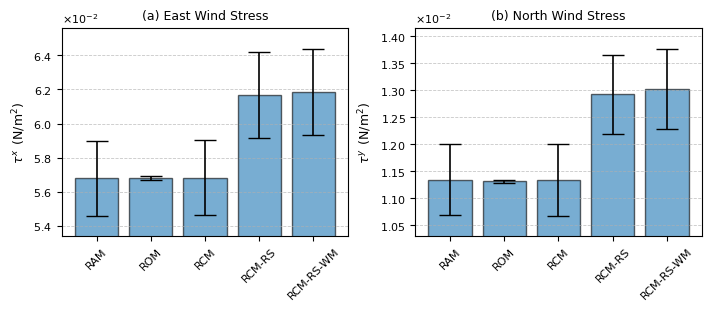

In [17]:
fig, ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(7,3))

ymean = np.array([d.variables['taux_mean'][it0:].data.mean(axis=0) for d in ds])
ystd = np.array([d.variables['taux_std'][it0:].data.mean(axis=0) for d in ds])
ax[0].bar(xpos, ymean, yerr=ystd, **bar_kwargs)
ax[0].set(
    xticks=xpos, 
    xticklabels=labels,    
    title='(a) East Wind Stress',
    ylabel=r'$\tau^x\,$ (N/m$^2$)',
    ylim=alim((ymean-ystd).min(), (ymean+ystd).max())
)

ymean = np.array([d.variables['tauy_mean'][it0:].data.mean(axis=0) for d in ds])
ystd = np.array([d.variables['tauy_std'][it0:].data.mean(axis=0) for d in ds])
ax[1].bar(xpos, ymean, yerr=ystd, **bar_kwargs)
ax[1].set(
    title='(b) North Wind Stress',
    ylabel=r'$\tau^y\,$ (N/m$^2$)',
    ylim=alim((ymean-ystd).min(), (ymean+ystd).max())
)

for a in ax: 
    a.tick_params(axis='x', rotation=45)
    set_plot_style(a, grid='y', sci_format='y')

plt.savefig(os.path.join(outdir, f'tau{suffix}.pdf'), **fig_kwargs) 

In [18]:
# Close data
for d in ds:
    d.close()